In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline 

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2022-11-10 03:04:38--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2022-11-10 03:04:38 (8.61 MB/s) - ‘names.txt’ saved [228145/228145]



In [ ]:
words = open("names.txt", "r").read().splitlines()

In [ ]:
chars = sorted(list(set(''.join(words))))
stoi = {c:i+1 for i, c in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [ ]:
block_size = 3
def build_dataset(words):
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for c in w + '.':
      idx = stoi[c]
      X.append(context)
      Y.append(idx)
      # print(f"{''.join(itos[x] for x in context)} --> {c}")
      context = context[1:] + [idx]
    
  x = torch.tensor(X)
  y = torch.tensor(Y)
  print(x.shape, y.shape)
  return x, y

In [ ]:
X, Y = build_dataset(words)

torch.Size([228146, 3]) torch.Size([228146])


In [ ]:
# embedding table lookup
C = torch.randn((27, 10))

In [ ]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 10])

In [ ]:
W1 = torch.randn((30, 100))
b1 = torch.randn(100)

In [ ]:
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
h.shape

torch.Size([228146, 100])

In [ ]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [ ]:
logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [ ]:
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)
probs.shape

torch.Size([228146, 27])

In [ ]:
probs[0, :].sum(0)
emb.shape

torch.Size([228146, 3, 10])

In [ ]:
loss = -probs[torch.arange(emb.shape[0]), Y].log().mean()
loss

tensor(18.4700)

## Now let's make it more respectable

In [ ]:
# training/validation/test
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g, requires_grad=True)
W1 = torch.randn((30, 100), generator=g, requires_grad=True)
b1 = torch.randn(100, generator=g, requires_grad=True)
W2 = torch.randn((100, 27), generator=g, requires_grad=True)
b2 = torch.randn(27, generator=g, requires_grad=True)
paramaters = [C, W1, b1, W2, b2]

In [ ]:
W1.requires_grad

True

In [ ]:
sum(p.nelement() for p in paramaters)

6097

In [ ]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [ ]:
lri = []
lossi = []
stepi = []

# forward pass
for i in range(200000):
  # minibatch construct
  idx = torch.randint(0, Xtr.shape[0], (128,))
  emb = C[Xtr[idx]]
  h1 = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h1 @ W2 + b2  
  # counts = logits.exp()
  # probs = counts / counts.sum(1, keepdim=True)
  # loss = -probs[torch.arange(emb.shape[0]), Y].log().mean()
  loss = F.cross_entropy(logits, Ytr[idx])
  for p in paramaters:
    p.grad = None
  loss.backward()
  # lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in paramaters:
    p.data += -lr * p.grad
  # lri.append(lr)
  lossi.append(loss.log10().item())
  stepi.append(i) 
print(loss.item())

2.0101850032806396


In [ ]:
# evaluate on val
emb = C[Xval] # (19452, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Yval)
loss


tensor(2.1807, grad_fn=<NllLossBackward0>)

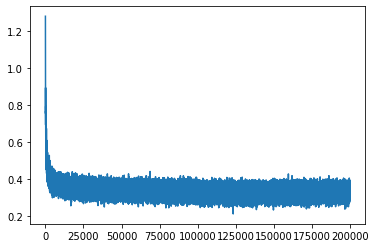

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
# to spot a good learning rate, here roughly 0.1
plt.plot(lri, lossi)

In [ ]:
logits.max(1)

torch.return_types.max(
values=tensor([4.5427, 3.0581, 4.5030,  ..., 2.0203, 3.2739, 3.1448],
       grad_fn=<MaxBackward0>),
indices=tensor([ 1, 12,  1,  ..., 25, 12,  1]))

In [ ]:
Y[:32]

tensor([ 5, 13, 13,  1, 15, 12,  9, 22,  9,  1,  1, 22,  1,  9, 19,  1,  2,  5,
        12, 12,  1, 19, 15, 16,  8,  9,  1,  3,  8,  1, 18, 12])

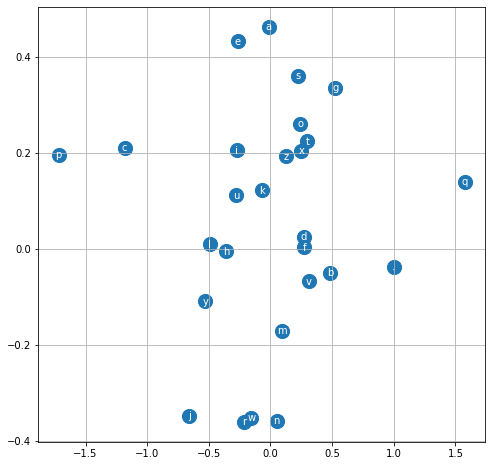

In [ ]:
# visualize embedding with dim 2D
plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

In [ ]:
# text generation.
g = torch.Generator().manual_seed(32084209852)

context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [ ]:
for _ in range(20):

  out = []
  context = [0] * block_size # initialize with all ....
  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    idx = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [idx]
    out.append(idx)
    if idx == 0:
      break
  print(''.join(itos[i] for i in out))

hea.
nyasiker.
aarai.
dee.
sol.
azarmondraida.
sakey.
kir.
zadie.
jamion.
lorah.
crononanys.
dejas.
arlyn.
luv.
baabrylanna.
yurrious.
mauson.
jovy.
madaulan.
